In [1]:
from torch import nn, optim, tensor, max
from torchvision import transforms
import torchvision.datasets as torch_data
from torch.utils.data import DataLoader

In [2]:
class NetBatchNorm(nn.Module):
    def __init__(self, layers, should_apply_batch_norm=True):
        super(NetBatchNorm, self).__init__()
        self.should_apply_batch_norm = should_apply_batch_norm
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for (i, (input_size, output_size)) in enumerate(zip(layers[:-1], layers[1:])):
            linear = nn.Linear(input_size, output_size)
            nn.init.xavier_uniform_(linear.weight)
            self.layers.append(linear)
            if i < len(layers) - 2:
                self.batch_norms.append(nn.BatchNorm1d(output_size))

    def forward(self, activation):
        for layer, batch_norm in zip(self.layers, self.batch_norms):
            if self.should_apply_batch_norm:
                activation = nn.SiLU()(batch_norm(layer(activation)))
            else:
                activation = nn.SiLU()(layer(activation))
        output_layer = self.layers[-1]
        activation = output_layer(activation)
        return activation

In [3]:
train_data = torch_data.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
validation_data = torch_data.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

In [4]:
train_loader = DataLoader(train_data, batch_size=128)
validation_loader = DataLoader(validation_data, batch_size=5000)

In [5]:
layers = [784, 512, 512, 256, 10]
model_batch = NetBatchNorm(layers)
model_no_batch = NetBatchNorm(layers, should_apply_batch_norm=False)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer_batch = optim.Adam(model_batch.parameters(), lr=0.003)
optimizer_no_batch = optim.Adam(model_no_batch.parameters(), lr=0.003)

In [7]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=5):
    metrics = {
        "training_loss": [],
        "validation_accuracy": []
    }
    model.train()
    for epoch in range(epochs):
        print(f"########## Starting epoch {epoch + 1} ##########")
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_hat = model(x.view(-1, 28 * 28))
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

        metrics["training_loss"].append(loss.item())
        print(f"Train epoch {epoch + 1} finished.")
        print(f"\tTrain Loss: {loss.item()}")

        correct = 0
        for x, y in validation_loader:
            y_hat = model(x.view(-1, 28 * 28))
            _, label = max(y_hat, 1)
            correct += (label == y).sum().item()
        acc = 100 * (correct / len(validation_data))

        metrics["validation_accuracy"].append(acc)
        print(f"\tValidation Acc: {acc}")

    return metrics

In [8]:
train_metrics_batch = train(model_batch, criterion, train_loader, validation_loader, optimizer_batch, epochs=1)

########## Starting epoch 1 ##########
Train epoch 1 finished.
	Train Loss: 0.2352415770292282
	Validation Acc: 96.39


In [9]:
train_metrics_no_batch = train(model_no_batch, criterion, train_loader, validation_loader, optimizer_no_batch, epochs=20)

########## Starting epoch 1 ##########
Train epoch 1 finished.
	Train Loss: 0.443219929933548
	Validation Acc: 95.67
########## Starting epoch 2 ##########
Train epoch 2 finished.
	Train Loss: 0.11443688720464706
	Validation Acc: 95.76
########## Starting epoch 3 ##########


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt

NameError: name 'train_metrics_no_batch' is not defined

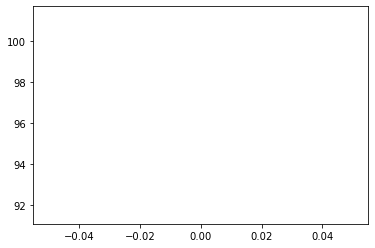

In [11]:
plt.plot(train_metrics_batch["validation_accuracy"], label="Accuracy With Batch Norm")
plt.plot(train_metrics_no_batch["validation_accuracy"], label="Accuracy Without Batch Norm")
plt.legend()
plt.show()
plt.plot(train_metrics_batch["training_loss"], label="Loss With Batch Norm")
plt.plot(train_metrics_no_batch["training_loss"], label="Loss Without Batch Norm")
plt.legend()
plt.show()

In [12]:
import numpy as np

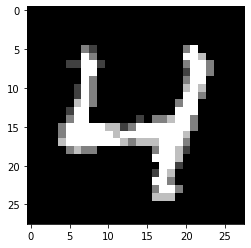

The model sees a 4


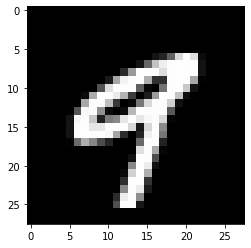

The model sees a 9


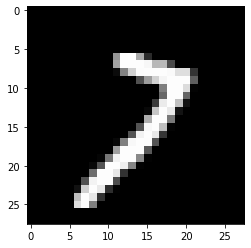

The model sees a 7


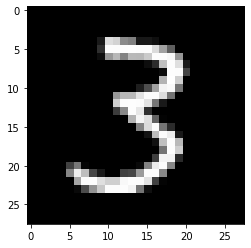

The model sees a 3


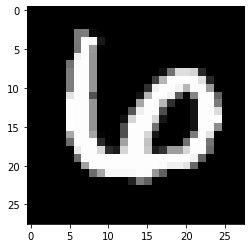

The model sees a 6


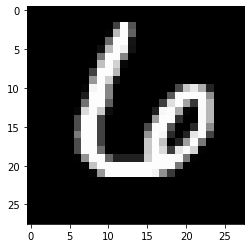

The model sees a 6


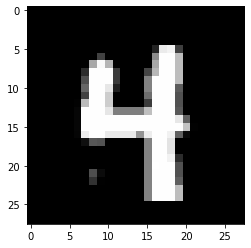

The model sees a 4


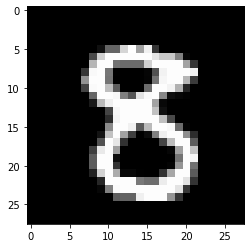

The model sees a 3


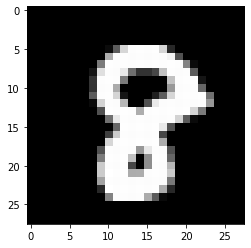

The model sees a 8


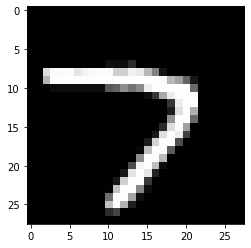

The model sees a 7


In [14]:
for i in range(10):
    r = np.random.randint(0, len(validation_data) - 1)

    img = validation_data[r][0][0].numpy()
    plt.imshow(img, cmap="gray")
    plt.show()

    model_batch.eval()
    pred = model_batch(validation_data[r][0].view(-1, 784))
    _, label = max(pred, 1)
    print(f"The model sees a {label[0]}")

In [28]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
count_trainable_parameters(model_batch)

801034